<a href="https://colab.research.google.com/github/NamasteAI/ToxicCommentsClassifier/blob/main/ToxicCommentClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#df = pd.read_csv('/content/drive/MyDrive/KaggleToxicCommentDataset/train.csv')
df = pd.read_csv('/Users/itscodezero/Documents/UOL/M6-NLP/MMA/data/train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [7]:
# Add a new column 'non-toxic' to the DataFrame with values 0 or 1, where 0 represent the comment falls under any one of the category
df['non-toxic'] = (df['toxic'] == 0) & (df['severe_toxic'] == 0) & (df['obscene'] == 0) & (df['threat'] == 0) & (df['insult'] == 0) & (df['identity_hate'] == 0)
df['non-toxic'] = df['non-toxic'].astype(int)  # Convert boolean to integer (True -> 1, False -> 0)

In [8]:
toxicity_counts = df.iloc[:, 2:].apply(pd.Series.value_counts)
print(toxicity_counts)

    toxic  severe_toxic  obscene  threat  insult  identity_hate  non-toxic
0  144277        157976   151122  159093  151694         158166      16225
1   15294          1595     8449     478    7877           1405     143346


In [9]:
# Get the positive count of each category
category_totals = toxicity_counts.iloc[1].sort_values(ascending=False)
print(category_totals)

non-toxic        143346
toxic             15294
obscene            8449
insult             7877
severe_toxic       1595
identity_hate      1405
threat              478
Name: 1, dtype: int64


<Axes: >

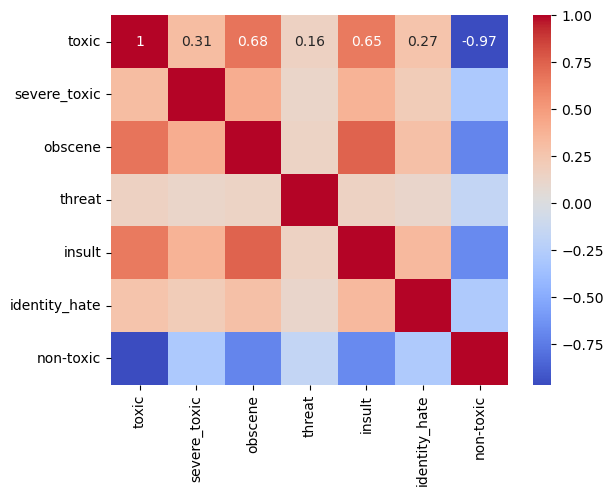

In [10]:

# Calculate the correlation matrix 
corr_matrix = df.iloc[:, 2:].corr()

# Plot the correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

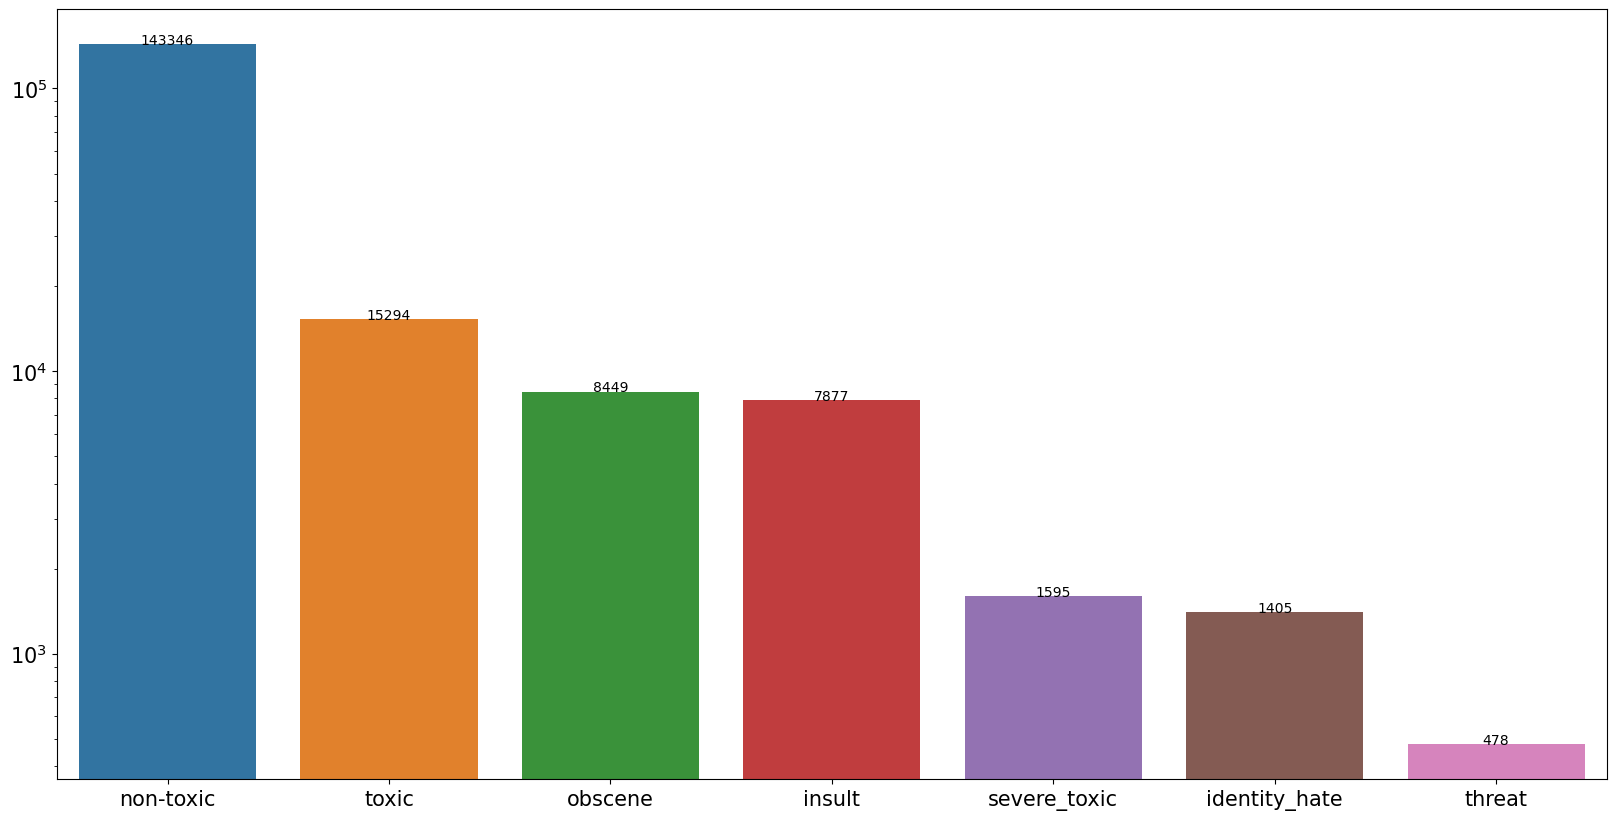

In [11]:

plt.figure(figsize=(20, 10))
bp = sns.barplot(x=category_totals.index, y=category_totals.values)
for i in range(len(category_totals)):
    bp.text(i, category_totals.iloc[i], category_totals.iloc[i], ha = 'center')

bp.set_yscale("log")
bp.tick_params(labelsize=15)

## Dataset balancing

/var/folders/kf/mvzkysrj6zbb9fg2ksrxn7zc0000gn/T/ipykernel_3165/3104332450.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp.text(i, category_totals[i], category_totals[i], ha = 'center')


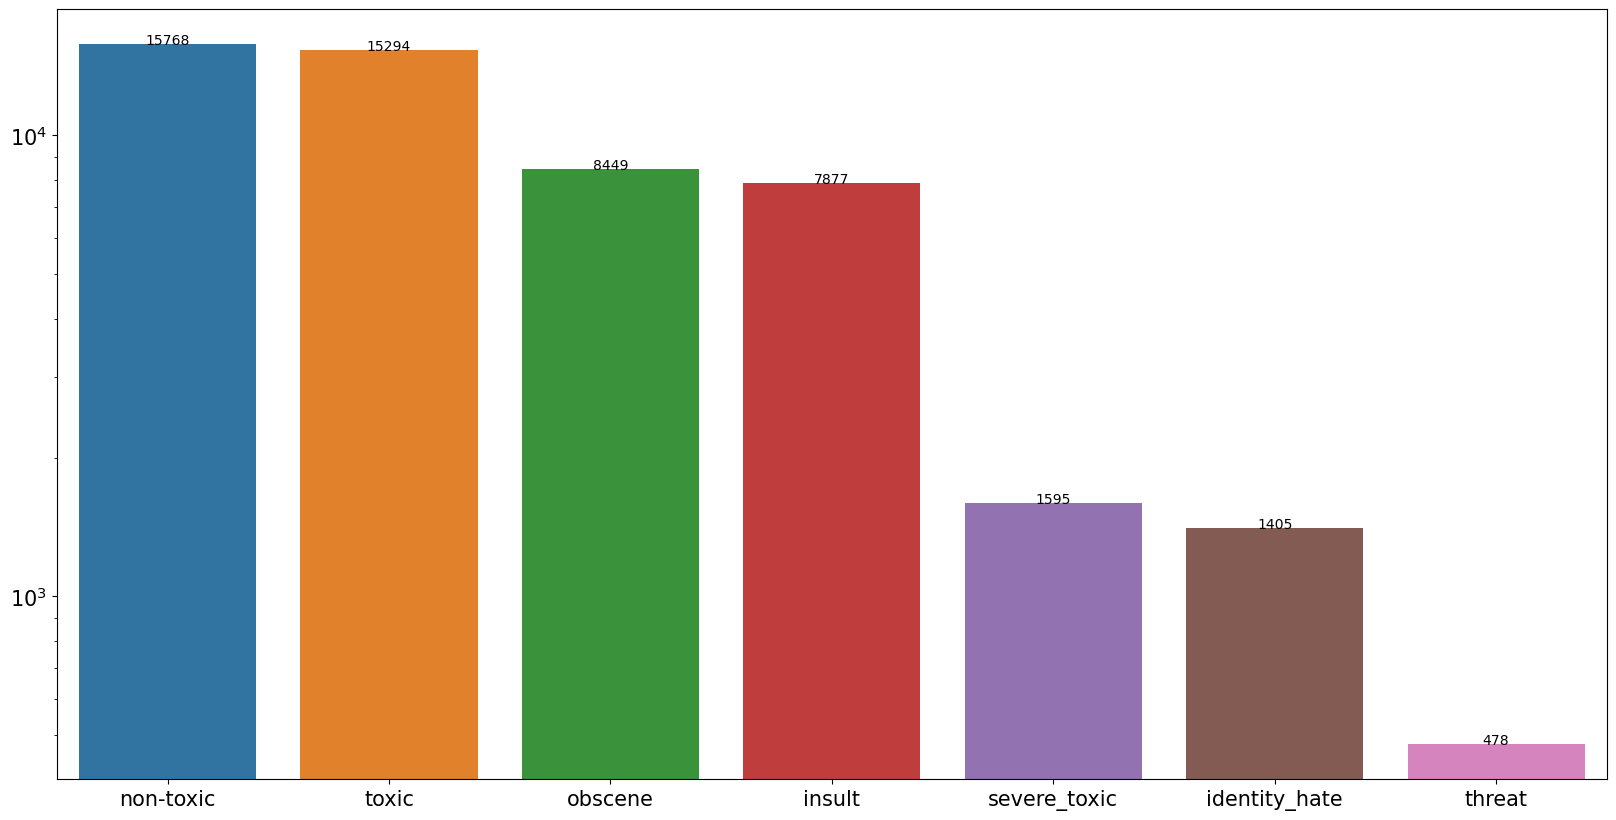

In [12]:
df_balanced = pd.concat([df[df['non-toxic'] == 1].sample(frac=0.11), df.loc[df['non-toxic'] == 0]])

# Shuffle the DataFrame
df_balanced = df_balanced.sample(frac=1)

toxicity_counts = df_balanced.iloc[:, 2:].apply(pd.Series.value_counts)
category_totals = toxicity_counts.iloc[1].sort_values(ascending=False)

plt.figure(figsize=(20, 10))
bp = sns.barplot(x=category_totals.index, y=category_totals.values)
#show the count on the barplot
for i in range(len(category_totals)):
    bp.text(i, category_totals[i], category_totals[i], ha = 'center')
bp.set_yscale("log")
bp.tick_params(labelsize=15)

In [13]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# Load English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_lg")

processed_tokens = []
processed_comments = []

for doc in nlp.pipe(df_balanced['comment_text'].astype('unicode').values, batch_size=100):
    tokens=[token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_digit and token.is_alpha]
    # make lowercase and remove whitespaces
    t_list=[token.lower() for token in tokens]
    processed_tokens.append(t_list)
    processed_comments.append(' '.join(t_list))



print('Unprocessed text:', df_balanced['comment_text'].head())
# Apply preprocessing to the 'comment_text' column
df_balanced['processed_comment_text'] = processed_comments
df_balanced['processed_tokens'] = processed_tokens
print('Processed text:', df_balanced['processed_comment_text'].head())

print('processed_tokens:',df_balanced['processed_tokens'].head())

/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_lg' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Unprocessed text: 109000                      U R A DUMB ASS ! 95.114.245.254
54900     Richard Machowicz \n\nRegarding your striking ...
109505    "\nlet's see, how many times he has used the f...
3008      Hey Roy.  Go fukk yourself you gay bich.\n\nYa...
91502                          your grammar is retarded two
Name: comment_text, dtype: object
Processed text: 109000                                         u r dumb ass
54900     richard machowicz striking edit summary look d...
109505    let time f word lie get apology gross offender...
3008                  hey roy fukk gay bich ya u hear pussy
91502                                      grammar retarded
Name: processed_comment_text, dtype: object
processed_tokens: 109000                                    [u, r, dumb, ass]
54900     [richard, machowicz, striking, edit, summary, ...
109505    [let, time, f, word, lie, get, apology, gross,...
3008        [hey, roy, fukk, gay, bich, ya, u, hear, pussy]
91502                         

('fuck', 'suck', 'shit', 'like', 'wikipedia', 'nigger', 'fucking', 'hate', 'ass', 'faggot', 'u', 'page', 'know', 'gay', 'die', 'edit', 'fat', 'block', 'moron', 'people')
(8961, 4538, 3647, 3635, 3398, 3332, 3086, 2741, 2680, 2629, 2580, 2571, 2497, 2264, 2170, 2091, 1970, 1957, 1932, 1925)


/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


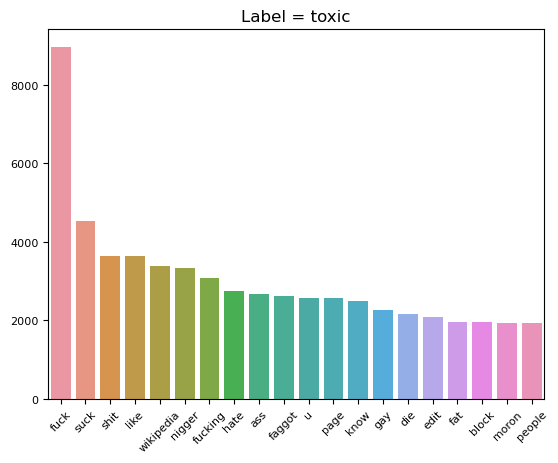

<Figure size 2000x2000 with 0 Axes>

('fuck', 'suck', 'shit', 'ass', 'faggot', 'u', 'fucking', 'die', 'cunt', 'nigger', 'cock', 'bitch', 'wikipedia', 'fucksex', 'yourselfgo', 'fucker', 'kill', 'dick', 'cocksucker', 'piece')
(6109, 3261, 1887, 1842, 1575, 1365, 1362, 1164, 1036, 1016, 914, 778, 687, 624, 621, 593, 585, 525, 509, 507)


/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


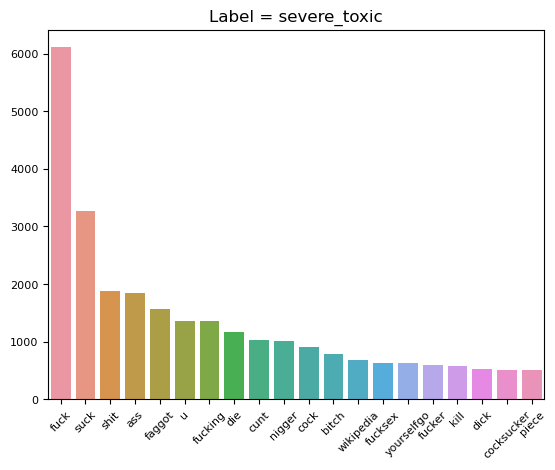

<Figure size 2000x2000 with 0 Axes>

('fuck', 'suck', 'shit', 'fucking', 'nigger', 'ass', 'u', 'faggot', 'cunt', 'wikipedia', 'like', 'bitch', 'dick', 'know', 'page', 'fat', 'cock', 'die', 'edit', 'bullshit')
(8859, 4001, 3228, 2998, 2748, 2586, 2046, 1832, 1769, 1695, 1620, 1468, 1307, 1300, 1283, 1282, 1252, 1211, 1159, 1085)


/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


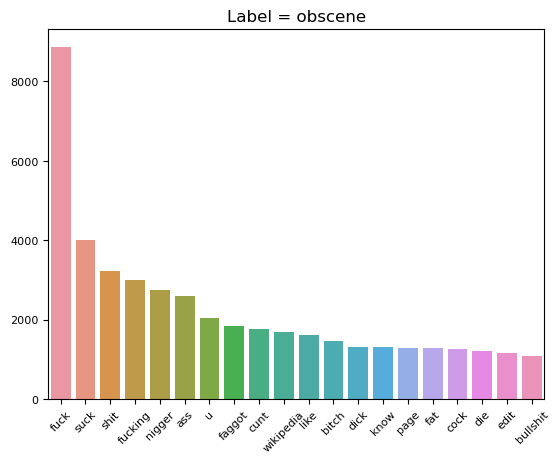

<Figure size 2000x2000 with 0 Axes>

('die', 'ass', 'kill', 'go', 'block', 'jim', 'wales', 'fuck', 'page', 'fucking', 'ban', 'talk', 'wikipedia', 'murder', 'live', 'fuckin', 'rvv', 'blank', 'di', 'edie')
(1176, 772, 521, 298, 188, 158, 157, 143, 137, 136, 136, 121, 120, 109, 105, 101, 96, 94, 91, 90)


/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


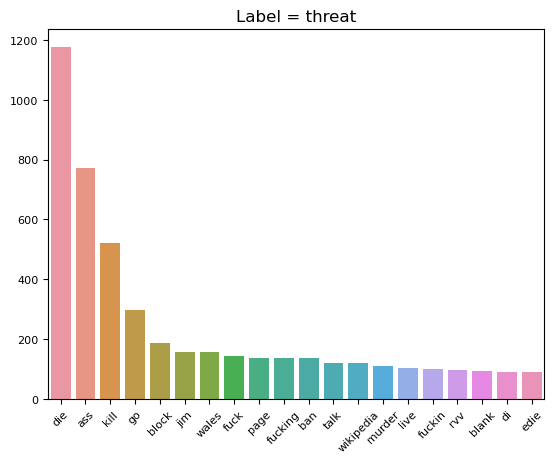

<Figure size 2000x2000 with 0 Axes>

('fuck', 'suck', 'nigger', 'fucking', 'faggot', 'u', 'ass', 'fat', 'shit', 'cunt', 'like', 'moron', 'hate', 'hi', 'bitch', 'jew', 'wikipedia', 'know', 'die', 'page')
(6850, 3644, 2805, 2632, 2468, 1953, 1944, 1927, 1703, 1674, 1629, 1507, 1429, 1399, 1397, 1307, 1293, 1278, 1254, 1103)


/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


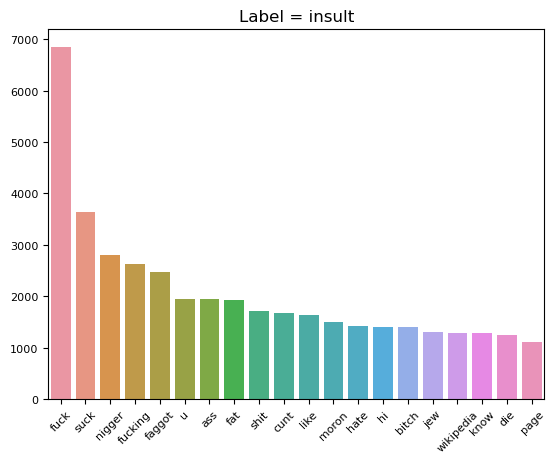

<Figure size 2000x2000 with 0 Axes>

('nigger', 'fat', 'jew', 'fuck', 'gay', 'die', 'faggot', 'suck', 'nigga', 'fucking', 'huge', 'shit', 'like', 'cunt', 'stupid', 'ass', 'mexicans', 'bitch', 'hate', 'bunksteve')

/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)



(2995, 1322, 1314, 941, 935, 885, 703, 523, 506, 488, 430, 412, 406, 402, 394, 373, 363, 356, 315, 278)


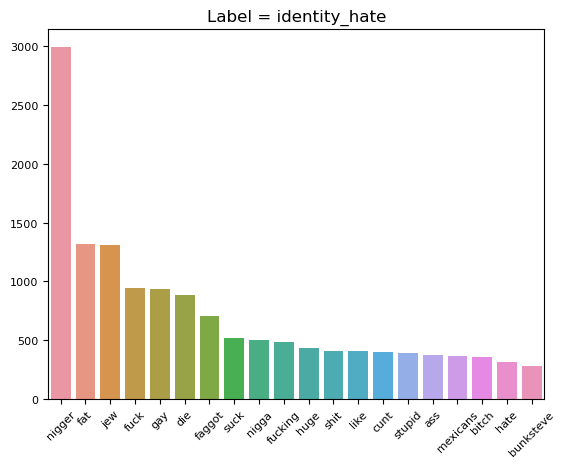

<Figure size 2000x2000 with 0 Axes>

In [16]:
target_columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

for label in target_columns:
    filtered_df = df_balanced[df_balanced[label] == 1]
    word_list = list(filtered_df['processed_tokens'].explode())
    most_common = Counter(word_list).most_common(20)
    top_words, word_counts = zip(*most_common)
    print(top_words)
    print(word_counts)
    # Create and customize the plot
    ax = sns.barplot(x=list(top_words), y=list(word_counts))

    ax.set_title(f'Label = {label}', fontsize=12)
    ax.tick_params(labelsize=8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.figure(figsize=(20, 20))
    plt.show() 



In [17]:
df_balanced.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'non-toxic', 'processed_comment_text',
       'processed_tokens'],
      dtype='object')

In [18]:
X = df_balanced['processed_comment_text']
# take the columns from 2 to the 1 before the last one i.e. exclude 'non-toxic' and 'processed_comment_text'
y = df_balanced[df_balanced.columns[2:-3]].values
#print column names from y
print(df_balanced.columns[2:-3])

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


In [19]:
from tensorflow.keras.layers import TextVectorization

In [20]:
MAX_FEATURES = 200000

In [21]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [22]:
vectorizer.adapt(X.values)

In [23]:
vectorizer('hello, how are you?')

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([226,   1,   1, ...,   0,   0,   0])>

In [24]:
vectorizer_text= vectorizer(X.values)

In [25]:
vectorizer_text

<tf.Tensor: shape=(31993, 1800), dtype=int64, numpy=
array([[   25,   642,   325, ...,     0,     0,     0],
       [ 1981, 37618, 10481, ...,     0,     0,     0],
       [   99,    17,   561, ...,     0,     0,     0],
       ...,
       [  190,    15, 11449, ...,     0,     0,     0],
       [    9,   993,    31, ...,     0,     0,     0],
       [  249,     0,     0, ...,     0,     0,     0]])>

In [26]:
dataset = tf.data.Dataset.from_tensor_slices((vectorizer_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [27]:
batchX, batchy = dataset.as_numpy_iterator().next()

In [28]:
train = dataset.take(int(len(dataset)* .7))
val = dataset.skip(int(len(dataset)* .7)).take(int(len(dataset)* .2))
test = dataset.skip(int(len(dataset)* .9)).take(int(len(dataset)* .1))

### Create Sequential Model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding

In [30]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation= 'tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation= 'relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6,activation='sigmoid'))

In [31]:
model.compile(loss = tf.keras.losses.binary_crossentropy, optimizer='Adam')

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(train, epochs=1, validation_data=val)

1400/1400 ━━━━━━━━━━━━━━━━━━━━ 527s 375ms/step - loss: 0.2906 - val_loss: 0.1892


In [34]:
model.evaluate(test)

200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.1711


0.17370662093162537

In [35]:
history.history

{'loss': [0.23633599281311035], 'val_loss': [0.1892222911119461]}

# Evaluation metrics

In [36]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [37]:
pre = Precision()
re = Recall()
cat_acc = CategoricalAccuracy()

In [38]:

for batch in test.as_numpy_iterator():
    # Divide the batch into X_true and y_true
    X_true, y_true = batch

    # Make a prediction
    y_pred = model.predict(X_true)

    # flatten the prediction
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    pre.update_state(y_true, y_pred)
    re.update_state(y_true, y_pred)
    cat_acc.update_state(y_true, y_pred)


    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

2024-04-27 15:14:11.140348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [39]:
print (f'Precision {pre.result().numpy()}, Recall {re.result().numpy()}, Accuracy {cat_acc.result().numpy()}')

Precision 0.8782051205635071, Recall 0.7051758766174316, Accuracy 0.11500000208616257
